## Amazon Fine Food Review - Logistic Regression Algorithm

In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import seaborn as sns

C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
filtered_data['Score'].value_counts()

1    83876
0    16124
Name: Score, dtype: int64

In [4]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [9]:
final_score = final['Score']
final_score.shape

(87773,)

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:04<00:00, 1362.27it/s]


## 1) Applying Logistic Regression

## 1.1) Applying Logistic Regression on BOW, SET 1

In [13]:
# Getting all the imports done

from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

In [14]:
final['Cleaned_Text']=preprocessed_reviews
final_review = final[['Cleaned_Text','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [15]:
# Please write all the code with proper documentation
# TIME BASED SPILTTING
# SIMPLE CROSS VALIDATION

X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(56174, 1) (56174,)


In [16]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [17]:
df_post_split['Score'].value_counts()

1    47504
0     8670
Name: Score, dtype: int64

In [18]:
# For every observation of class 1, randomly sample from class 0 without replacement
#x_negetive_upsample = resample(x_negetive, replace = True, n_samples=17000)
x_negative_downsample = resample(x_negetive,replace=True,n_samples=30000,random_state=123) 

In [19]:
print(x_negative_downsample.shape, type(x_positive))

(30000, 2) <class 'pandas.core.frame.DataFrame'>


In [20]:
#df_upsample = pd.concat([x_positive,x_negetive_upsample])
df_upsample = pd.concat([x_positive,x_negative_downsample])
type(df_upsample)
df_upsample.head()

,Cleaned_Text,Score
0,bought apartment infested fruit flies hours tr...,1
1,really good idea final product outstanding use...,1
2,received shipment could hardly wait try produc...,1
3,nothing product bother link top page buy used ...,1
4,love stuff sugar free rot gums tastes good goi...,1


In [21]:
df_upsample['Score'].value_counts()

1    47504
0    30000
Name: Score, dtype: int64

In [22]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_1_train = df_upsample['Score']
print(X_Train.shape, Y_1_train.shape)

(77504, 1) (77504,)


In [23]:
# BoW -- transform with unigram and bigram

ngram_vect = CountVectorizer(min_df=10)
D1_Train = ngram_vect.fit_transform(X_Train['Cleaned_Text'])
D1_Cv = ngram_vect.transform(X_1_cv['Cleaned_Text'])
D1_Test = ngram_vect.transform(X_test['Cleaned_Text'])
print(D1_Train.shape,D1_Cv.shape,D1_Test.shape)

(77504, 11334) (14044, 11334) (17555, 11334)


In [24]:
n_cv = D1_Cv.get_shape()[0]
n_train = D1_Train.get_shape()[0]
n_test = D1_Test.get_shape()[0]
print(n_train)
print(n_cv)
print(n_test)

77504
14044
17555


In [25]:
# Standardization Process
# Changes done as suggested

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(D1_Train)
D1_Train = scaler.transform(D1_Train)
D1_Cv = scaler.transform(D1_Cv)
D1_Test = scaler.transform(D1_Test)

print(D1_Train.shape)
print(D1_Cv.shape)
print(D1_Test.shape)

C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(77504, 11334)
(14044, 11334)
(17555, 11334)


In [26]:
D1_Train=D1_Train.astype('int')
D1_Cv=D1_Cv.astype('int')
D1_Test=D1_Test.astype('int')
Y_1_train=Y_1_train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [27]:
# Applying Logistic Regression with L2 Regularization

cv_score = []
train_score = []

# creating list of lamda for LR
lamda = list((0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(lamda):
    lr = LogisticRegression(C = i)
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    lr.fit(D1_Train,Y_1_train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(lr.predict(D1_Cv[j:j+1000]))
        predict_cv_prob.extend(lr.predict_log_proba(D1_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(lr.predict(D1_Train[k:k+1000]))
        predict_train_prob.extend(lr.predict_log_proba(D1_Train[k:k+1000])[:,1])
    
    print(len(predict_train_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for Lamda = %f is %f%%' % (i,accuracy_cv))
    print('\nCV AUC for Lamda = %f is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_1_train,predict_train_prob)
    accuracy_train = accuracy_score(Y_1_train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for Lamda = %f is %f%%' % (i,accuracy_train))
    print('\nTrain AUC for Lamda = %f is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

77504
14044

CV Accuracy for Lamda = 0.000010 is 90.949872%

CV AUC for Lamda = 0.000010 is 0.919567%

Train Accuracy for Lamda = 0.000010 is 90.085673%

Train AUC for Lamda = 0.000010 is 0.967433%


  9%|███████▌                                                                           | 1/11 [00:01<00:14,  1.41s/it]

77504
14044

CV Accuracy for Lamda = 0.000100 is 90.771860%

CV AUC for Lamda = 0.000100 is 0.925781%

Train Accuracy for Lamda = 0.000100 is 93.906121%

Train AUC for Lamda = 0.000100 is 0.985440%


 18%|███████████████                                                                    | 2/11 [00:03<00:13,  1.51s/it]

77504
14044

CV Accuracy for Lamda = 0.001000 is 89.753631%

CV AUC for Lamda = 0.001000 is 0.911316%

Train Accuracy for Lamda = 0.001000 is 96.529211%

Train AUC for Lamda = 0.001000 is 0.994098%


 27%|██████████████████████▋                                                            | 3/11 [00:05<00:15,  1.90s/it]

77504
14044

CV Accuracy for Lamda = 0.010000 is 87.994873%

CV AUC for Lamda = 0.010000 is 0.884189%

Train Accuracy for Lamda = 0.010000 is 98.216866%

Train AUC for Lamda = 0.010000 is 0.997763%


 36%|██████████████████████████████▏                                                    | 4/11 [00:11<00:20,  2.91s/it]

77504
14044

CV Accuracy for Lamda = 0.100000 is 86.328681%

CV AUC for Lamda = 0.100000 is 0.853923%

Train Accuracy for Lamda = 0.100000 is 99.100692%

Train AUC for Lamda = 0.100000 is 0.999253%


 45%|█████████████████████████████████████▋                                             | 5/11 [00:22<00:31,  5.33s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 1.000000 is 84.854742%

CV AUC for Lamda = 1.000000 is 0.832135%

Train Accuracy for Lamda = 1.000000 is 99.695500%

Train AUC for Lamda = 1.000000 is 0.999764%


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:52<01:03, 12.75s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 10.000000 is 84.911706%

CV AUC for Lamda = 10.000000 is 0.836157%

Train Accuracy for Lamda = 10.000000 is 99.630987%

Train AUC for Lamda = 10.000000 is 0.999655%


 64%|████████████████████████████████████████████████████▊                              | 7/11 [01:12<00:59, 14.89s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 100.000000 is 85.132441%

CV AUC for Lamda = 100.000000 is 0.838728%

Train Accuracy for Lamda = 100.000000 is 99.522605%

Train AUC for Lamda = 100.000000 is 0.999550%


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [01:28<00:45, 15.32s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 1000.000000 is 85.118200%

CV AUC for Lamda = 1000.000000 is 0.838514%

Train Accuracy for Lamda = 1000.000000 is 99.553571%

Train AUC for Lamda = 1000.000000 is 0.999573%


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [01:46<00:32, 16.23s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 10000.000000 is 85.139561%

CV AUC for Lamda = 10000.000000 is 0.838583%

Train Accuracy for Lamda = 10000.000000 is 99.549701%

Train AUC for Lamda = 10000.000000 is 0.999570%


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [02:05<00:16, 16.83s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 100000.000000 is 84.812019%

CV AUC for Lamda = 100000.000000 is 0.832596%

Train Accuracy for Lamda = 100000.000000 is 99.695500%

Train AUC for Lamda = 100000.000000 is 0.999736%


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:27<00:00, 18.56s/it]


[0.9195674670012395, 0.925780864340079, 0.9113159814166234, 0.8841886998993099, 0.8539233854681564, 0.8321354726554643, 0.8361567511471311, 0.8387275215480536, 0.8385138667402856, 0.8385830106365885, 0.8325958320779172]
[0.9674326439177051, 0.9854395794740092, 0.9940984776720557, 0.9977628694425732, 0.9992534653222185, 0.9997640033821713, 0.9996548357331312, 0.9995503603205343, 0.9995731296311889, 0.9995700246295048, 0.9997356268244078]


In [28]:
import math
alpha = []
for n in range(len(lamda)):
    alpha1 = lamda[n]
    x = math.log(alpha1)
    print(alpha1,x)
    alpha.append(x)

1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.001 -6.907755278982137
0.01 -4.605170185988091
0.1 -2.3025850929940455
1 0.0
10 2.302585092994046
100 4.605170185988092
1000 6.907755278982137
10000 9.210340371976184
100000 11.512925464970229


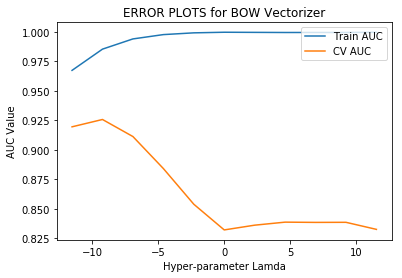

In [29]:
# Plotting Train_AUC and CV_AUC against Lamda
plt.plot(alpha,train_auc)
plt.plot(alpha,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Lamda')
plt.ylabel('AUC Value')
plt.show()

In [30]:
# Getting the optimal Alpha Based to CV AUC
optimal_lamda_auc = lamda[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best Lamda = %f' % optimal_lamda_auc)
print(best_cv_auc)

AUC Metric Best Lamda = 0.000100
0.926


In [40]:
# Applying Best K on D_Test

test_neigh = LogisticRegression(C = 0.0001)
test_neigh.fit(D1_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []
predict_test_logprob = []
predict_train_logprob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)


17555
17555
Algo Run Successfully on D_Test


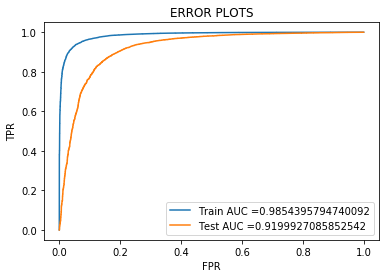

In [41]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [42]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
26857 3143 1580 45924
[[26857  3143]
 [ 1580 45924]]
Test Confusion Matrix
2095 819 801 13840
[[ 2095   819]
 [  801 13840]]


##### Heatmap on the model created by L2 Regularizer

Text(0.5,1,'Confusion Matrix of Train Data')

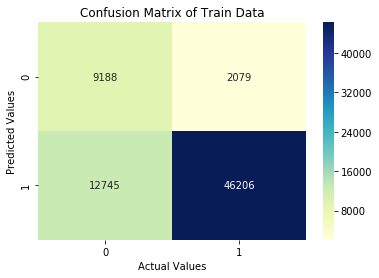

In [156]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

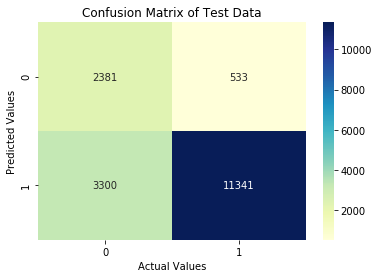

In [157]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

In [70]:
# Weight Vector for L2 Regularization

w_l2 = test_neigh.coef_
print(w_l2)
l2_count = np.count_nonzero(w_l2)
print("Total number of non-zero values in the weight vector : ",np.count_nonzero(w_l2))

[[-0.00896849  0.00041388 -0.00107146 ... -0.00209     0.00151501
   0.00416625]]
Total number of non-zero values in the weight vector :  11334


In [37]:
# Feature Importance on L2 Regularization

feature = ngram_vect.get_feature_names()
coefs_with_fns = sorted(zip(test_neigh.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-0.1152	disappointed   		0.1778	great          
	-0.0950	worst          		0.1387	love           
	-0.0928	bad            		0.1374	best           
	-0.0904	disappointing  		0.1241	delicious      
	-0.0857	waste          		0.1190	loves          
	-0.0852	terrible       		0.1041	good           
	-0.0844	awful          		0.1023	perfect        
	-0.0809	horrible       		0.0973	excellent      
	-0.0762	money          		0.0883	highly         
	-0.0734	unfortunately  		0.0878	wonderful      


#### Performing the Perturbation Test by adding noise 

In [47]:
# Pertubation Testing -- Adding Noise

e = np.random.normal(0,0.01)
D1_Train.data = D1_Train.data + e
print(D1_Train.shape)

(77504, 11334)


In [48]:
# Applying Logistic Regression with L2 Regularization ( Pertubation Testing Phase )

cv_score = []
train_score = []

# creating list of lamda for LR
lamda = list((0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(lamda):
    lr = LogisticRegression(C = i)
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    lr.fit(D1_Train,Y_1_train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(lr.predict(D1_Cv[j:j+1000]))
        predict_cv_prob.extend(lr.predict_log_proba(D1_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(lr.predict(D1_Train[k:k+1000]))
        predict_train_prob.extend(lr.predict_log_proba(D1_Train[k:k+1000])[:,1])
    
    print(len(predict_train_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for Lamda = %f is %f%%' % (i,accuracy_cv))
    print('\nCV AUC for Lamda = %f is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_1_train,predict_train_prob)
    accuracy_train = accuracy_score(Y_1_train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for Lamda = %f is %f%%' % (i,accuracy_train))
    print('\nTrain AUC for Lamda = %f is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

77504
14044

CV Accuracy for Lamda = 0.000010 is 90.942751%

CV AUC for Lamda = 0.000010 is 0.919604%

Train Accuracy for Lamda = 0.000010 is 90.088254%

Train AUC for Lamda = 0.000010 is 0.967446%


  9%|███████▌                                                                           | 1/11 [00:01<00:10,  1.01s/it]

77504
14044

CV Accuracy for Lamda = 0.000100 is 90.757619%

CV AUC for Lamda = 0.000100 is 0.925792%

Train Accuracy for Lamda = 0.000100 is 93.906121%

Train AUC for Lamda = 0.000100 is 0.985446%


 18%|███████████████                                                                    | 2/11 [00:02<00:10,  1.19s/it]

77504
14044

CV Accuracy for Lamda = 0.001000 is 89.746511%

CV AUC for Lamda = 0.001000 is 0.911303%

Train Accuracy for Lamda = 0.001000 is 96.536953%

Train AUC for Lamda = 0.001000 is 0.994101%


 27%|██████████████████████▋                                                            | 3/11 [00:05<00:13,  1.65s/it]

77504
14044

CV Accuracy for Lamda = 0.010000 is 87.987753%

CV AUC for Lamda = 0.010000 is 0.884148%

Train Accuracy for Lamda = 0.010000 is 98.219447%

Train AUC for Lamda = 0.010000 is 0.997764%


 36%|██████████████████████████████▏                                                    | 4/11 [00:10<00:18,  2.69s/it]

77504
14044

CV Accuracy for Lamda = 0.100000 is 86.328681%

CV AUC for Lamda = 0.100000 is 0.853865%

Train Accuracy for Lamda = 0.100000 is 99.101982%

Train AUC for Lamda = 0.100000 is 0.999254%


 45%|█████████████████████████████████████▋                                             | 5/11 [00:19<00:28,  4.69s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 1.000000 is 85.139561%

CV AUC for Lamda = 1.000000 is 0.838908%

Train Accuracy for Lamda = 1.000000 is 99.512283%

Train AUC for Lamda = 1.000000 is 0.999543%


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:37<00:43,  8.71s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 10.000000 is 84.897465%

CV AUC for Lamda = 10.000000 is 0.835751%

Train Accuracy for Lamda = 10.000000 is 99.640019%

Train AUC for Lamda = 10.000000 is 0.999659%


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:59<00:50, 12.50s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 100.000000 is 84.854742%

CV AUC for Lamda = 100.000000 is 0.832950%

Train Accuracy for Lamda = 100.000000 is 99.681307%

Train AUC for Lamda = 100.000000 is 0.999719%


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [01:20<00:45, 15.25s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 1000.000000 is 85.175164%

CV AUC for Lamda = 1000.000000 is 0.838769%

Train Accuracy for Lamda = 1000.000000 is 99.545830%

Train AUC for Lamda = 1000.000000 is 0.999564%


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [01:37<00:31, 15.64s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 10000.000000 is 84.876104%

CV AUC for Lamda = 10000.000000 is 0.833476%

Train Accuracy for Lamda = 10000.000000 is 99.672275%

Train AUC for Lamda = 10000.000000 is 0.999710%


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [01:59<00:17, 17.65s/it]C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


77504
14044

CV Accuracy for Lamda = 100000.000000 is 85.054116%

CV AUC for Lamda = 100000.000000 is 0.837096%

Train Accuracy for Lamda = 100000.000000 is 99.611633%

Train AUC for Lamda = 100000.000000 is 0.999630%


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:19<00:00, 18.30s/it]


[0.9196043684141533, 0.9257923350618691, 0.9113029296862583, 0.8841476273148363, 0.8538645013083519, 0.8389077397063811, 0.8357508187858398, 0.8329496247947086, 0.8387689136980904, 0.8334756801692311, 0.8370955170367297]
[0.9674464588946896, 0.985445503887392, 0.9941011153446726, 0.9977641170568091, 0.9992540210648927, 0.9995433440692714, 0.9996591679998877, 0.9997194709919164, 0.9995644650976758, 0.9997104864853485, 0.9996297795975075]


In [43]:
# Fitting the model on Test Data
# Applying Best K on D_Test

test_neigh_pert = LogisticRegression(C = 0.0001)
test_neigh_pert.fit(D1_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []
predict_test_logprob = []
predict_train_logprob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh_pert.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh_pert.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh_pert.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh_pert.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)


17555
17555
Algo Run Successfully on D_Test


In [75]:
# Finding the % change in weight vector for the pertubation testing

w_new_l2 = test_neigh_pert.coef_
w_l2 = w_l2 + 10**-6
w_new_l2 = w_new_l2 + 10**-6
percentage_change_vector = (abs((w_l2 - w_new_l2)/w_l2))*100

In [76]:
percentiles_vector = np.percentile(percentage_change_vector,np.arange(0,100,10))
percentiles_vector

array([1.87184065e-02, 1.16867935e+02, 2.30776204e+02, 3.31745114e+02,
       4.28607448e+02, 5.37514929e+02, 6.80214348e+02, 8.88528820e+02,
       1.24562843e+03, 2.36443092e+03])

In [77]:
percentiles_vector_70_100 = np.percentile(percentage_change_vector,np.arange(70,100,5))
percentiles_vector_70_100

array([ 888.52881997, 1034.77012751, 1245.62842576, 1592.03944682,
       2364.43091681, 4761.37178988])

In [78]:
percentiles_vector_70_100_5 = np.percentile(percentage_change_vector,np.arange(70,100,1))
percentiles_vector_70_100_5

array([  888.52881997,   913.04001052,   941.45951642,   970.56341246,
        1000.85657202,  1034.77012751,  1071.02633633,  1108.11874763,
        1152.75654189,  1192.63020193,  1245.62842576,  1297.58323086,
        1356.3579155 ,  1424.52025384,  1498.93222824,  1592.03944682,
        1682.75633898,  1804.33315132,  1969.66397702,  2144.91380954,
        2364.43091681,  2585.81480929,  2870.67962886,  3290.09249785,
        3877.55032308,  4761.37178988,  5804.11755636,  7906.28354973,
       12289.01904769, 24281.37252139])

In [79]:
percentiles_vector_90_100 = np.percentile(percentage_change_vector,np.arange(90,100,1))
percentiles_vector_90_100

array([ 2364.43091681,  2585.81480929,  2870.67962886,  3290.09249785,
        3877.55032308,  4761.37178988,  5804.11755636,  7906.28354973,
       12289.01904769, 24281.37252139])

In [80]:
percentiles_vector_94_100 = np.percentile(percentage_change_vector,np.arange(94,100,1))
percentiles_vector_94_100

array([ 3877.55032308,  4761.37178988,  5804.11755636,  7906.28354973,
       12289.01904769, 24281.37252139])

In [81]:
percentiles_vector_95_99 = np.percentile(percentage_change_vector,np.arange(94,95,.1))
percentiles_vector_95_99

array([3877.55032308, 3955.58243588, 4015.36327152, 4089.86512893,
       4194.84460535, 4271.80824297, 4351.81632515, 4447.80726455,
       4558.62813602, 4649.76357291])

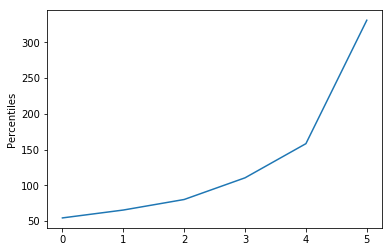

In [57]:
plt.plot(percentiles_vector_94_100)
plt.ylabel('Percentiles')
plt.show()

In [82]:
perc = np.percentile(percentage_change_vector,94)

In [83]:
#percentage_change_vector= list(percentage_change_vector)
value_index = np.where(percentage_change_vector > perc)

In [84]:
weight_index_list = list(zip(value_index[0], value_index[1]))
feature_index = []
for cord in weight_index_list:
    feature_index.append(cord[1])

count = 0
collinear_feature = []
for i in feature_index:
    #print(feature[i])
    collinear_feature.append(feature[i])
    count += 1
    

print("\n Some of the collinear feature names : ",collinear_feature[0:100])
print("\n Total Count of Features that are collinear : ",count)


 Some of the collinear feature names :  ['aafco', 'absolutly', 'accepted', 'accomplished', 'accomplishment', 'achieve', 'acknowledge', 'acted', 'action', 'addendum', 'adding', 'additon', 'adhesive', 'adult', 'advised', 'affected', 'afterwards', 'aggressive', 'ah', 'aka', 'akita', 'altering', 'alternatives', 'altogether', 'amount', 'ana', 'anal', 'anemic', 'angeles', 'animals', 'announcement', 'annoyance', 'answer', 'antibiotics', 'anyhow', 'anyway', 'apologize', 'apply', 'aroma', 'arsenic', 'associate', 'astounded', 'atrocious', 'attack', 'attributable', 'bacteria', 'bag', 'bahlsen', 'bakes', 'bang', 'banged', 'barbecue', 'barista', 'battle', 'beaba', 'beating', 'beers', 'behold', 'beige', 'bell', 'beverage', 'bikram', 'bil', 'biscotti', 'blamed', 'blander', 'blandness', 'blender', 'blue', 'boiling', 'bounty', 'boxing', 'boy', 'bragging', 'branding', 'breadcrumbs', 'breaks', 'breeze', 'brighter', 'brightness', 'brochure', 'brothers', 'bs', 'bubbles', 'buckwheat', 'bud', 'building', 'b

#### Checking the sparsity created by L1 Regularization :

In [44]:
# Applying Logistic Regression with L1 Regularization to measure the sparsity created

cv_score = []
train_score = []

# creating list of lamda for LR
lamda = list((0.00001,0.0001,0.001,0.01,0.1,1))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(lamda):
    lr_l1 = LogisticRegression(C = i,penalty='l1')
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    lr_l1.fit(D1_Train,Y_1_train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(lr_l1.predict(D1_Cv[j:j+1000]))
        predict_cv_prob.extend(lr_l1.predict_log_proba(D1_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(lr_l1.predict(D1_Train[k:k+1000]))
        predict_train_prob.extend(lr_l1.predict_log_proba(D1_Train[k:k+1000])[:,1])
    
    print(len(predict_train_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for Lamda = %f is %f%%' % (i,accuracy_cv))
    print('\nCV AUC for Lamda = %f is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_1_train,predict_train_prob)
    accuracy_train = accuracy_score(Y_1_train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for Lamda = %f is %f%%' % (i,accuracy_train))
    print('\nTrain AUC for Lamda = %f is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

77504
14044

CV Accuracy for Lamda = 0.000010 is 18.491883%

CV AUC for Lamda = 0.000010 is 0.500000%

Train Accuracy for Lamda = 0.000010 is 38.707680%

Train AUC for Lamda = 0.000010 is 0.500000%


 17%|██████████████                                                                      | 1/6 [00:00<00:02,  1.98it/s]

77504
14044

CV Accuracy for Lamda = 0.000100 is 18.491883%

CV AUC for Lamda = 0.000100 is 0.500000%

Train Accuracy for Lamda = 0.000100 is 38.707680%

Train AUC for Lamda = 0.000100 is 0.500000%


 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  2.01it/s]

77504
14044

CV Accuracy for Lamda = 0.001000 is 87.553404%

CV AUC for Lamda = 0.001000 is 0.901942%

Train Accuracy for Lamda = 0.001000 is 81.821583%

Train AUC for Lamda = 0.001000 is 0.899162%


 50%|██████████████████████████████████████████                                          | 3/6 [00:01<00:01,  1.75it/s]

77504
14044

CV Accuracy for Lamda = 0.010000 is 90.059812%

CV AUC for Lamda = 0.010000 is 0.934868%

Train Accuracy for Lamda = 0.010000 is 93.586137%

Train AUC for Lamda = 0.010000 is 0.981174%


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:03<00:01,  1.06it/s]

77504
14044

CV Accuracy for Lamda = 0.100000 is 88.407861%

CV AUC for Lamda = 0.100000 is 0.893641%

Train Accuracy for Lamda = 0.100000 is 98.028489%

Train AUC for Lamda = 0.100000 is 0.997183%


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.87s/it]

77504
14044

CV Accuracy for Lamda = 1.000000 is 85.538308%

CV AUC for Lamda = 1.000000 is 0.845199%

Train Accuracy for Lamda = 1.000000 is 99.495510%

Train AUC for Lamda = 1.000000 is 0.999562%


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:47<00:00, 13.21s/it]


[0.5, 0.5, 0.901942063839848, 0.9348680475105859, 0.8936408605813153, 0.845199094223368]
[0.5, 0.5, 0.8991617460284047, 0.981173966753677, 0.9971832396570114, 0.9995624091304591]


In [45]:
import math
alpha = []
for n in range(len(lamda)):
    alpha1 = lamda[n]
    x = math.log(alpha1)
    print(x)
    alpha.append(x)

-11.512925464970229
-9.210340371976182
-6.907755278982137
-4.605170185988091
-2.3025850929940455
0.0


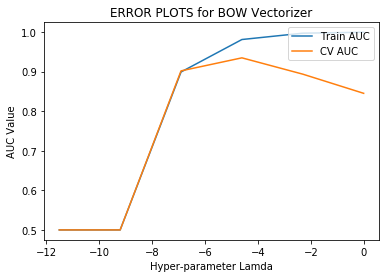

In [46]:
# Plotting Train_AUC and CV_AUC against Lamda
plt.plot(alpha,train_auc)
plt.plot(alpha,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Lamda')
plt.ylabel('AUC Value')
plt.show()

In [47]:
# Getting the optimal Alpha Based to CV AUC
optimal_lamda_auc = lamda[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best Lamda = %f' % optimal_lamda_auc)
print(best_cv_auc)

AUC Metric Best Lamda = 0.010000
0.935


In [62]:
# Applying Best Lamda on D_Test

test_neigh_l1 = LogisticRegression(C = 0.01,penalty = 'l1')
test_neigh_l1.fit(D1_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []
predict_test_logprob = []
predict_train_logprob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh_l1.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh_l1.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh_l1.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh_l1.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)


17555
17555
Algo Run Successfully on D_Test


In [63]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
27081 2919 2052 45452
[[27081  2919]
 [ 2052 45452]]
Test Confusion Matrix
2220 694 1052 13589
[[ 2220   694]
 [ 1052 13589]]


##### Heatmap of Confusion Matrix created on the model created with L1 Regularizer

Text(0.5,1,'Confusion Matrix of Train Data')

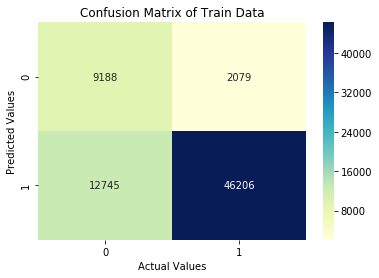

In [158]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

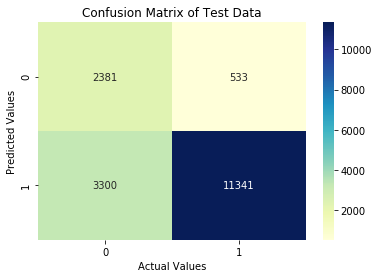

In [159]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

In [71]:
# Weight Vector for L1 Regularization

w_l1 = test_neigh_l1.coef_
print(w_l1)
l1_count = np.count_nonzero(w_l1)
print("Total number of non-zero values in the weight vector : ",np.count_nonzero(w_l1))

[[-0.00602148  0.          0.         ...  0.          0.
   0.        ]]
Total number of non-zero values in the weight vector :  3645


In [72]:
# %age of Sparsity Created 

percentage_feature_count = round((abs((l2_count - l1_count)/l2_count)*100),3)
print("Total %age of feature zeroed out due to L1 Regularizarion : ", percentage_feature_count )

Total %age of feature zeroed out due to L1 Regularizarion :  67.84


In [73]:
# Feature Importance on L1 Regularization

feature = ngram_vect.get_feature_names()
coefs_with_fns = sorted(zip(test_neigh_l1.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-0.3703	worst          		0.8308	great          
	-0.3642	disappointed   		0.5397	best           
	-0.2557	awful          		0.5189	delicious      
	-0.2552	terrible       		0.3665	good           
	-0.2420	disappointing  		0.3651	excellent      
	-0.2401	bad            		0.3426	love           
	-0.2392	taste          		0.3326	perfect        
	-0.2239	horrible       		0.3272	wonderful      
	-0.2085	waste          		0.3119	loves          
	-0.1954	unfortunately  		0.2607	highly         


##### We performed L1 regularization and as a result 67.84% of total features zeroed out. 
##### We also performed Perturbation Test to check for collinearity among the features . The result shows 680 features ( out of 11334 features )  are collinear to one other. 

## 1.2) Applying Logistic Regression on TF-IDF, SET 2

##### We are performing cross validation with GridSearch method on the TFIDF vectorizer.

##### We didnt perform any sort off class balancing here as we used the 'class_weight' parameter of Logistic Regrssion and set it to 'balanced' . 

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
# Time Series Split

X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
tuned_param = [{'C':[0.00001,0.0001,0.001,0.01,0.1,1]}]

In [68]:
# Creating Tfidf Vectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 10)
D2_Train = tfidf_vect.fit_transform(X_1['Cleaned_Text'])
D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", tfidf_vect.get_feature_names()[0:10])
print(D2_Train.shape,D2_Test.shape)

Some feature names :  ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
(70218, 40504) (17555, 40504)


In [69]:
scaler_tfidf = StandardScaler(with_mean=False)
scaler_tfidf.fit(D2_Train)
D2_Train = scaler_tfidf.transform(D2_Train)
D2_Test = scaler_tfidf.transform(D2_Test)
print(D2_Train.shape,D2_Test.shape)

(70218, 40504) (17555, 40504)


In [70]:
n_test = D2_Test.get_shape()[0]
n_train = D2_Train.get_shape()[0]
print(n_train,n_test)

70218 17555


In [71]:
# Using GridSearchCV
tfidf_model = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tuned_param,cv = 5, scoring = 'roc_auc')
tfidf_model.fit(D2_Train,Y_1)

print(tfidf_model.best_estimator_)
print("AUC SCORE : ",tfidf_model.score(D2_Test,Y_test))

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC SCORE :  0.9518268312905669


In [75]:
# Fitting the model on test data

test_neigh = LogisticRegression(C = 0.0001,class_weight = 'balanced')
test_neigh.fit(D2_Train,Y_1)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D2_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


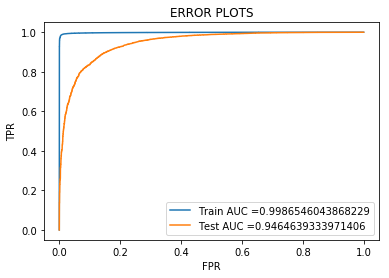

In [76]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [77]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
11233 34 1434 57517
[[11233    34]
 [ 1434 57517]]
Test Confusion Matrix
2273 641 929 13712
[[ 2273   641]
 [  929 13712]]


Text(0.5,1,'Confusion Matrix of Train Data')

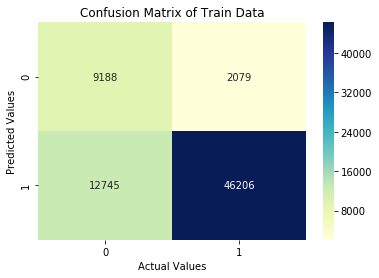

In [161]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

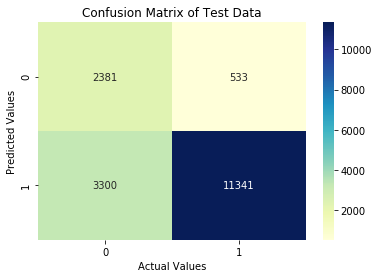

In [160]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

In [94]:
# Feature Importance on L2 Regularization

feature = tfidf_vect.get_feature_names()
coefs_with_fns = sorted(zip(tfidf_model.best_estimator_.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-0.0274	disappointed   		0.0399	great          
	-0.0260	worst          		0.0276	love           
	-0.0234	terrible       		0.0268	best           
	-0.0229	awful          		0.0244	delicious      
	-0.0229	horrible       		0.0233	good           
	-0.0219	disappointing  		0.0209	perfect        
	-0.0217	bad            		0.0205	loves          
	-0.0205	waste          		0.0188	favorite       
	-0.0193	return         		0.0183	nice           
	-0.0193	money          		0.0176	highly         


## 1.3) Applying Logistic Regression on Average_Word2Vec, SET 3

##### We performed Feature Engineering on the Average Word2Vec vectorizer by taking the count of the words in the review text as a extra feature. 

In [83]:
final['Cleaned_Text']=preprocessed_reviews
#final['Cleaned_Summary'] = preprocessed_summary
final['Word Count'] = final['Cleaned_Text'].apply(lambda x:len(x.split()))
#final['Summary Word Count'] = final['Cleaned_Summary'].apply(lambda x:len(x.split()))
final.head()
word_count = final['Word Count']

In [84]:
final_review = final[['Cleaned_Text','Word Count','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [85]:
# Time Series Split

X_Train, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
tuned_param = [{'C':[0.00001,0.0001,0.001,0.01,0.1,1]}]

In [86]:
# Creating Word2Vec model on Training Data 

list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:10])
print("="*100)

70218
[('great', 0.8276934027671814), ('decent', 0.8115479946136475), ('fantastic', 0.7662653923034668), ('awesome', 0.7537726163864136), ('terrific', 0.7435007095336914), ('amazing', 0.7258817553520203), ('excellent', 0.6711327433586121), ('wise', 0.6530591249465942), ('yummy', 0.6402285099029541), ('tasty', 0.6271358728408813)]
Total Words Present  15758
Sample Words :  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within']


In [87]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 70218/70218 [04:02<00:00, 289.18it/s]


70218
[-1.54477715e-01 -1.25336026e-02  1.21077308e-01  8.04021447e-02
 -9.30019138e-02  3.90860399e-01  6.40151762e-02  1.83501832e-01
  1.83871335e-01 -4.33901457e-01  5.39389519e-01 -1.15178645e-02
  2.64906869e-01 -9.79439288e-02 -7.37914064e-02 -2.26268931e-01
  1.79797591e-01 -3.66937958e-02  1.49446002e-01  1.01696795e-01
  9.75151027e-02 -3.08168449e-01  3.61228438e-01 -1.15138987e-01
  1.75303867e-01 -2.29825888e-01 -6.88080206e-02 -2.26223625e-01
 -1.74562926e-01 -2.50235448e-01  1.14688805e-01  4.74092174e-01
 -1.63933878e-01 -3.08790752e-01 -9.59109614e-01 -4.52783446e-01
  2.86387934e-01 -5.16435351e-01 -8.83073936e-04 -4.04587606e-01
 -1.71569559e-01  2.36983702e-02  2.03710533e-01 -1.20843874e-02
 -2.62158470e-01  8.94450013e-01 -6.03243059e-01 -6.68688853e-01
  2.38582211e-01 -9.67355972e-02]


In [88]:
# Applying Word2Vec for Vectorization of X_test

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

17555


In [89]:
# Creating Average Word2Vec Vector for Test Data

sent_vect_test = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_test.append(sentence_vec)
print(len(sent_vect_test))
print(sent_vect_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [01:00<00:00, 287.84it/s]


17555
[-1.36482343 -0.2780526   0.05189467  0.25068517  0.43578938  0.49996195
  0.25767373 -0.1967419   0.13386065 -0.38438305  0.05798182 -0.84187759
  0.10540663  0.54045647 -0.0400746  -0.32469268  0.36881295 -0.2452042
  0.42497767  0.49879502  0.65631439 -0.29328541 -0.33695245  0.02103293
  0.25968292  0.51590624 -0.39362707 -0.61814763 -0.19050736 -0.04107351
 -0.22510337  1.36645022  0.27211266  0.04995622 -0.26450612 -0.72758514
 -0.13774616 -0.62043119  0.26241042 -0.2699211  -0.28011217 -0.43148334
  0.37131868  0.00684359  0.75674663  0.94337131  0.68113747  0.04533273
  0.58965219  0.31516088]


In [90]:
X_Train_count  =  X_Train['Word Count'].values.reshape(-1,1)
X_Test_count = X_test['Word Count'].values.reshape(-1,1)

In [91]:
#standardising word count feature
import warnings
warnings.filterwarnings('ignore')
word_scalar = StandardScaler()
word_scalar.fit(X_Train_count) 
X_Train_count = word_scalar.transform(X_Train_count)
X_Test_count = word_scalar.transform(X_Test_count)

In [92]:
D3_Train = np.hstack((sent_vect_train,X_Train_count))
D3_Test = np.hstack((sent_vect_test,X_Test_count))

In [93]:
n_train = len(D3_Train)
n_test = len(D3_Test)
print(n_train)
print(n_test)

70218
17555


In [94]:
# Standardization Process  when we are doing Feature Engineering

from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D3_Train)
D3_Train = scaler.transform(D3_Train)
D3_Test = scaler.transform(D3_Test)

print(D3_Train.shape)
print(D3_Test.shape)

(70218, 51)
(17555, 51)


In [21]:
# Standardization Process when we are not doing Feature Engineering

scaler = StandardScaler()
scaler.fit(sent_vect_train)
D3_Train = scaler.transform(D3_Train)
D3_Test = scaler.transform(D3_Test)

print(D3_Train.shape)
print(D3_Test.shape)

(70218, 50)
(17555, 50)


In [95]:
# Using GridSearchCV
w2v_model_gs = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tuned_param,cv = 5, scoring = 'roc_auc')
w2v_model_gs.fit(D3_Train,Y_1)

print(w2v_model_gs.best_estimator_)
print("AUC SCORE : ",w2v_model_gs.score(D3_Test,Y_test))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC SCORE :  0.9022267176206268


In [123]:
# Fitting the model on test data

test_neigh = LogisticRegression(C = 0.1,class_weight = 'balanced')
test_neigh.fit(D3_Train,Y_1)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D3_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


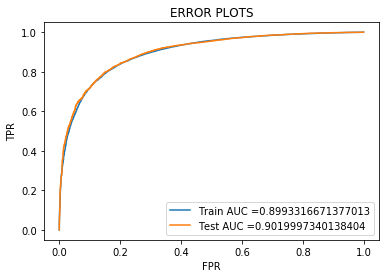

In [124]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [125]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
9449 1818 11579 47372
[[ 9449  1818]
 [11579 47372]]
Test Confusion Matrix
2481 433 2994 11647
[[ 2481   433]
 [ 2994 11647]]


In [95]:
import seaborn as sns

Text(0.5,1,'Confusion Matrix of Train Data')

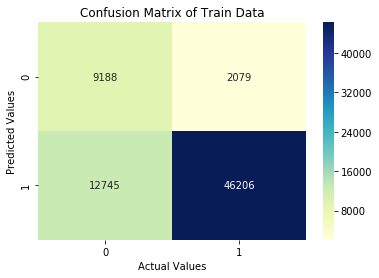

In [163]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

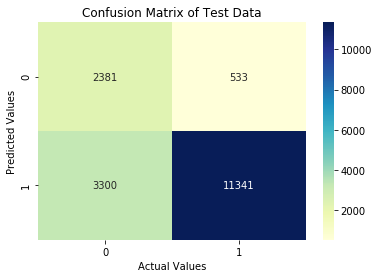

In [162]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

In [90]:
# Feature Importance on L2 Regularization

feature = w2v_words
coefs_with_fns = sorted(zip(w2v_model_gs.best_estimator_.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-7.6015	attracted      		7.4908	days           
	-3.3093	wait           		4.2062	stickers       
	-3.1154	within         		3.4646	hours          
	-3.0651	really         		3.2548	shipment       
	-2.4642	consider       		2.6654	good           
	-2.3747	trap           		2.5235	one            
	-2.2222	idea           		2.3280	term           
	-2.0874	received       		2.0724	could          
	-1.9469	use            		1.9828	crazy          
	-1.6627	window         		1.7334	may            


## 1.4) Applying Logistic Regression on Tf-Idf_Weighted-Average_Word2Vec, SET 4

##### We are using the previously created Tf-Idf and Word2Vec vectorizer .

In [120]:
# Time Series Split

X_Train, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
tuned_param = [{'C':[0.00001,0.0001,0.001,0.01,0.1,1]}]

In [121]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

70218


In [122]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|████████████████████████████████████████████████████████████████████████████| 70218/70218 [55:38<00:00, 21.03it/s]


70218


In [129]:
# Splitting the Test Data into sentences

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

17555


In [130]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_test = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_test.append(sent_vec)
print(len(tfidf_w2v_test))

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [13:06<00:00, 22.33it/s]


17555


In [131]:
n_train = len(tfidf_w2v_train)
n_test = len(tfidf_w2v_test)
print(n_train)
print(n_test)

70218
17555


In [132]:
# Standardization Process

scaler = StandardScaler()
scaler.fit(tfidf_w2v_train)
D4_Train = scaler.transform(tfidf_w2v_train)
D4_Test = scaler.transform(tfidf_w2v_test)

print(D4_Train.shape)
print(D4_Test.shape)

(70218, 50)
(17555, 50)


In [133]:
# Using GridSearchCV
tfidfw2v_model_gs = GridSearchCV(LogisticRegression(class_weight = 'balanced'),tuned_param,cv = 5, scoring = 'roc_auc')
tfidfw2v_model_gs.fit(D4_Train,Y_1)

print(tfidfw2v_model_gs.best_estimator_)
print("AUC SCORE : ",tfidfw2v_model_gs.score(D4_Test,Y_test))

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
AUC SCORE :  0.8786771918555731


In [149]:
# Fitting the model on test data

test_neigh = LogisticRegression(C = 0.1,class_weight = 'balanced')
test_neigh.fit(D4_Train,Y_1)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D4_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D4_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D4_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D4_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


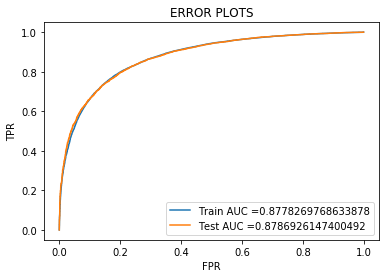

In [150]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [151]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
9188 2079 12745 46206
[[ 9188  2079]
 [12745 46206]]
Test Confusion Matrix
2381 533 3300 11341
[[ 2381   533]
 [ 3300 11341]]


Text(0.5,1,'Confusion Matrix of Train Data')

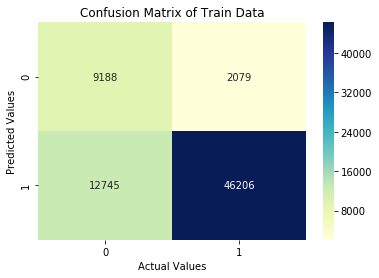

In [164]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Train Data')

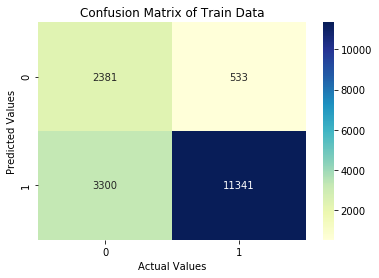

In [165]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

In [63]:
# Feature Importance on L2 Regularization

feature = w2v_words + tf_idf_features
coefs_with_fns = sorted(zip(w2v_model_gs.best_estimator_.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-0.7443	attracted      		0.7457	days           
	-0.4777	within         		0.4581	shipment       
	-0.3587	window         		0.4036	solution       
	-0.3426	wait           		0.3796	term           
	-0.3298	avoid          		0.3061	hardly         
	-0.3250	made           		0.2592	one            
	-0.3181	fruit          		0.2325	touching       
	-0.3168	idea           		0.2302	hours          
	-0.3122	received       		0.2202	long           
	-0.2990	really         		0.1880	surface        


### Conclusion 

In [81]:
# Importing Pretty Table
from prettytable import PrettyTable

In [154]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter Value','AUC']
x.add_row(['BOW','Lamda = 0.0001','0.92'])
x.add_row(['Tf-Idf','C = 0.0001','0.95'])
x.add_row(['Average Word2Vec','C = 0.1','0.90'])
x.add_row(['Tf-Idf_Average_Word2Vec','C = 0.1','0.88'])

print(x)

+-------------------------+-----------------------+------+
|        Vectorizer       | Hyper-Parameter Value | AUC  |
+-------------------------+-----------------------+------+
|           BOW           |     Lamda = 0.0001    | 0.92 |
|          Tf-Idf         |       C = 0.0001      | 0.95 |
|     Average Word2Vec    |        C = 0.1        | 0.90 |
| Tf-Idf_Average_Word2Vec |        C = 0.1        | 0.88 |
+-------------------------+-----------------------+------+


#### We have sampled top 100k datapoints that are highly imbalanced. We have thus balanced only the train datapoints with upsampling the negetive points for the BOW vectorizer. For the other vectorizer we have used the 'class_weight' parameter to balance the class.
#### We have also done feature engineering on the Average Word2Vec vectorizer by adding a new feature that contains the word count of the reviews to see if the model performance is increasing or not.¶

##### We have performed Perturbation test and also calculated sparsity on weight vector obtained after using L1 regularization on BOW.
##### We have also performed a feature importance to check if the model is performing good. We have listed the top 10 features for each class along with their weight vector values.